<img src="tmva_logo.gif" height="20%" width="20%">

# TMVA Classification Example Using a Convolutional Neural Network

## Declare Factory

Create the Factory class. Later you can choose the methods
whose performance you'd like to investigate. 

The factory is the major TMVA object you have to interact with. Here is the list of parameters you need to pass

 - The first argument is the base of the name of all the output
weightfiles in the directory weight/ that will be created with the 
method parameters 

 - The second argument is the output file for the training results
  
 - The third argument is a string option defining some general configuration for the TMVA session. For example all TMVA output can be suppressed by removing the "!" (not) in front of the "Silent" argument in the option string

In [1]:
TMVA::Tools::Instance();

 // for using Keras
gSystem->Setenv("KERAS_BACKEND","tensorflow");
// for setting openblas in single thread on SWAN
gSystem->Setenv("OMP_NUM_THREADS","1"); 
TMVA::PyMethodBase::PyInitialize();



auto outputFile = TFile::Open("CNN_ClassificationOutput.root", "RECREATE");

TMVA::Factory factory("TMVA_CNN_Classification", outputFile,
                      "!V:ROC:!Silent:Color:!DrawProgressBar:AnalysisType=Classification" ); 



## Declare DataLoader(s)

The next step is to declare the DataLoader class that deals with input variables 

Define the input variables that shall be used for the MVA training
note that you may also use variable expressions, which can be parsed by TTree::Draw( "expression" )]

In this case the input data consists of an image of 16x16 pixels. Each single pixel is a branch in a ROOT TTree

In [2]:
TMVA::DataLoader * loader = new TMVA::DataLoader("dataset");

int imgSize = 8 * 8; 
for(auto i = 0; i < imgSize; i++)
 {
     loader->AddVariable(Form("var%d",i),'F');
 }

## Setup Dataset(s)

Define input data file and signal and background trees

In [3]:
TString inputFileName = "images_data.root";

//TString inputFileName = "tmva_class_example.root";

auto inputFile = TFile::Open( inputFileName );

// --- Register the training and test trees

TTree *signalTree     = (TTree*)inputFile->Get("sig_tree");
TTree *backgroundTree = (TTree*)inputFile->Get("bkg_tree");

// global event weights per tree (see below for setting event-wise weights)
Double_t signalWeight     = 1.0;
Double_t backgroundWeight = 1.0;
   
// You can add an arbitrary number of signal or background trees
loader->AddSignalTree    ( signalTree,     signalWeight     );
loader->AddBackgroundTree( backgroundTree, backgroundWeight );


// Set individual event weights (the variables must exist in the original TTree)
//    for signal    : factory->SetSignalWeightExpression    ("weight1*weight2");
//    for background: factory->SetBackgroundWeightExpression("weight1*weight2");
//loader->SetBackgroundWeightExpression( "weight" );

// Apply additional cuts on the signal and background samples (can be different)
TCut mycuts = ""; // for example: TCut mycuts = "abs(var1)<0.5 && abs(var2-0.5)<1";
TCut mycutb = ""; // for example: TCut mycutb = "abs(var1)<0.5";

// Tell the factory how to use the training and testing events
//
// If no numbers of events are given, half of the events in the tree are used 
// for training, and the other half for testing:
//    loader->PrepareTrainingAndTestTree( mycut, "SplitMode=random:!V" );
// To also specify the number of testing events, use:

loader->PrepareTrainingAndTestTree( mycuts, mycutb,
                                    "nTrain_Signal=0:nTrain_Background=0:SplitMode=Random:NormMode=NumEvents:!V:!CalcCorrelations" );



//loader->PrepareTrainingAndTestTree(mycuts, mycutb,
//                                   "nTrain_Signal=5000:nTrain_Background=5000:nTest_Signal=5000:nTest_Background=5000:SplitMode=Random:NormMode=NumEvents:!V" ); 


DataSetInfo              : [dataset] : Added class "Signal"
                         : Add Tree sig_tree of type Signal with 10000 events
DataSetInfo              : [dataset] : Added class "Background"
                         : Add Tree bkg_tree of type Background with 10000 events


In [4]:
signalTree->Print();

******************************************************************************
*Tree    :sig_tree  : signal_tree                                            *
*Entries :    10000 : Total =         2601382 bytes  File  Size =    2572423 *
*        :          : Tree compression factor =   1.00                       *
******************************************************************************
*Br    0 :var0      : var0/F                                                 *
*Entries :    10000 : Total  Size=      40631 bytes  File Size  =      40150 *
*Baskets :        2 : Basket Size=      32000 bytes  Compression=   1.00     *
*............................................................................*
*Br    1 :var1      : var1/F                                                 *
*Entries :    10000 : Total  Size=      40631 bytes  File Size  =      40150 *
*Baskets :        2 : Basket Size=      32000 bytes  Compression=   1.00     *
*...................................................

# Booking Methods

Here we book the TMVA methods. We book a Likelihood based on KDE, a Fischer discriminant and a BDT

In [5]:

//Boosted Decision Trees
factory.BookMethod(loader,TMVA::Types::kBDT, "BDT",
                   "!V:NTrees=800:MinNodeSize=2.5%:MaxDepth=2:BoostType=AdaBoost:AdaBoostBeta=0.5:UseBaggedBoost:BaggedSampleFraction=0.5:SeparationType=GiniIndex:nCuts=20" );


Factory                  : Booking method: BDT
                         : 
DataSetFactory           : [dataset] : Number of events in input trees
                         : 
                         : 
                         : Number of training and testing events
                         : ---------------------------------------------------------------------------
                         : Signal     -- training events            : 5000
                         : Signal     -- testing events             : 5000
                         : Signal     -- training and testing events: 10000
                         : Background -- training events            : 5000
                         : Background -- testing events             : 5000
                         : Background -- training and testing events: 10000
                         : 


#### Booking Deep Neural Network

Here we book the new DNN of TMVA. If using master version you can use the new DL method
See the example TMVA_Higgs_Classification for a detailed description of the options

In [6]:
bool useDNN = true; 
bool useCNN = true; 
bool useKeras = false; // unfortunatly PyKeras does not work from C++ notebooks  

In [7]:
if (useDNN) { 
    
     TString inputLayoutString = "InputLayout=1|1|64"; 
     TString batchLayoutString= "BatchLayout=1|128|64";
     TString layoutString ("Layout=DENSE|64|TANH,DENSE|64|TANH,DENSE|64|TANH,DENSE|64|TANH,DENSE|1|LINEAR");
//                                                                                                                                                                                       
      // Training strategies 
      // one can catenate several training strategies 
      TString training1("LearningRate=1e-3,Momentum=0.9,Repetitions=1,"
                        "ConvergenceSteps=10,BatchSize=128,TestRepetitions=1,"
                        "MaxEpochs=20,WeightDecay=1e-4,Regularization=L2,"
                        "Optimizer=ADAM,DropConfig=0.0+0.0+0.0+0.");
  
      TString trainingStrategyString ("TrainingStrategy=");
      trainingStrategyString += training1; // + "|" + training2 + "|" + training3;

      // General Options.                                                                                                                                                                
      TString dnnOptions ("!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=None:"
                          "WeightInitialization=XAVIERUNIFORM");
      dnnOptions.Append (":"); dnnOptions.Append (inputLayoutString);
      dnnOptions.Append (":"); dnnOptions.Append (batchLayoutString);
      dnnOptions.Append (":"); dnnOptions.Append (layoutString);
      dnnOptions.Append (":"); dnnOptions.Append (trainingStrategyString);

      dnnOptions += ":Architecture=CPU";
      factory.BookMethod(loader, TMVA::Types::kDL, "DL_DENSE", dnnOptions);

}

Factory                  : Booking method: DL_DENSE
                         : 
                         : Parsing option string: 
                         : ... "!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=None:WeightInitialization=XAVIERUNIFORM:InputLayout=1|1|64:BatchLayout=1|128|64:Layout=DENSE|64|TANH,DENSE|64|TANH,DENSE|64|TANH,DENSE|64|TANH,DENSE|1|LINEAR:TrainingStrategy=LearningRate=1e-3,Momentum=0.9,Repetitions=1,ConvergenceSteps=10,BatchSize=128,TestRepetitions=1,MaxEpochs=20,WeightDecay=1e-4,Regularization=L2,Optimizer=ADAM,DropConfig=0.0+0.0+0.0+0.:Architecture=CPU"
                         : The following options are set:
                         : - By User:
                         :     <none>
                         : - Default:
                         :     Boost_num: "0" [Number of times the classifier will be boosted]
                         : Parsing option string: 
                         : ... "!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=None:WeightInitial

### Book Convolutional Neural Network in TMVA

   For building a CNN one needs to define 

   -  Input Layout :  number of channels (in this case = 1)  | image height | image width
   -  Batch Layout :  batch size | number of channels | image size = (height*width)

   Then one add Convolutional layers and MaxPool layers. 

   -  For Convolutional layer the option string has to be: 
      - CONV | number of units | filter height | filter width | stride height | stride width | padding height | paddig width | activation function 

      - note in this case we are using a filer 3x3 and padding=1 and stride=1 so we get the output dimension of the conv layer equal to the input

    - For the MaxPool layer: 
       - MAXPOOL  | pool height | pool width | stride height | stride width

   The RESHAPE layer is needed to flatten the output before the Dense layer


   Note that to run the CNN is required to have CPU  or GPU support 


In [8]:
if (useCNN) { 
    TString inputLayoutString("InputLayout=1|8|8");
                                                                                                
// Batch Layout                                                                                                                                     
    TString batchLayoutString("BatchLayout=32|1|64");
                                                   

TString layoutString("Layout=CONV|10|3|3|1|1|1|1|RELU,CONV|10|3|3|1|1|1|1|RELU,MAXPOOL|2|2|1|1,"
                     "RESHAPE|FLAT,DENSE|64|TANH,DENSE|1|LINEAR");
                                                                                                                                              


   // Training strategies.                                                                                                                          
   TString training0("LearningRate=1e-3,Momentum=0.9,Repetitions=1,"
                     "ConvergenceSteps=10,BatchSize=32,TestRepetitions=1,"
                     "MaxEpochs=30,WeightDecay=1e-4,Regularization=None,"
                     "Optimizer=ADAM,DropConfig=0.0+0.0+0.0+0.0");
 
   TString trainingStrategyString ("TrainingStrategy=");
   trainingStrategyString += training0; // + "|" + training1 + "|" + training2;   }
    
// General Options.                                                                                                                              
   TString cnnOptions ("!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=None:"
                       "WeightInitialization=XAVIERUNIFORM");

   cnnOptions.Append(":"); cnnOptions.Append(inputLayoutString);
   cnnOptions.Append(":"); cnnOptions.Append(batchLayoutString);
   cnnOptions.Append(":"); cnnOptions.Append(layoutString);
   cnnOptions.Append(":"); cnnOptions.Append(trainingStrategyString);
   cnnOptions.Append(":Architecture=GPU");

   //// New DL (CNN)                                                                                                                                


  factory.BookMethod(loader, TMVA::Types::kDL, "DL_CNN", cnnOptions);


}

Factory                  : Booking method: DL_CNN
                         : 
                         : Parsing option string: 
                         : ... "!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=None:WeightInitialization=XAVIERUNIFORM:InputLayout=1|8|8:BatchLayout=32|1|64:Layout=CONV|10|3|3|1|1|1|1|RELU,CONV|10|3|3|1|1|1|1|RELU,MAXPOOL|2|2|1|1,RESHAPE|FLAT,DENSE|64|TANH,DENSE|1|LINEAR:TrainingStrategy=LearningRate=1e-3,Momentum=0.9,Repetitions=1,ConvergenceSteps=10,BatchSize=32,TestRepetitions=1,MaxEpochs=30,WeightDecay=1e-4,Regularization=None,Optimizer=ADAM,DropConfig=0.0+0.0+0.0+0.0:Architecture=GPU"
                         : The following options are set:
                         : - By User:
                         :     <none>
                         : - Default:
                         :     Boost_num: "0" [Number of times the classifier will be boosted]
                         : Parsing option string: 
                         : ... "!H:V:ErrorStrategy=CROSSENTR

### Book Convolutional Neural Network in Keras using a generated model 

In [9]:
if (useKeras) { 
   factory.BookMethod(loader, TMVA::Types::kPyKeras, 
                       "PyKeras","H:!V:VarTransform=None:FilenameModel=model_cnn.h5:"
                       "FilenameTrainedModel=trained_model_cnn.h5:NumEpochs=20:BatchSize=128");
}

## Train Methods

In [10]:
factory.TrainAllMethods();

Factory                  : Train all methods
Factory                  : [dataset] : Create Transformation "I" with events from all classes.
                         : 
                         : Transformation, Variable selection : 
                         : Input : variable 'var0' <---> Output : variable 'var0'
                         : Input : variable 'var1' <---> Output : variable 'var1'
                         : Input : variable 'var2' <---> Output : variable 'var2'
                         : Input : variable 'var3' <---> Output : variable 'var3'
                         : Input : variable 'var4' <---> Output : variable 'var4'
                         : Input : variable 'var5' <---> Output : variable 'var5'
                         : Input : variable 'var6' <---> Output : variable 'var6'
                         : Input : variable 'var7' <---> Output : variable 'var7'
                         : Input : variable 'var8' <---> Output : variable 'var8'
                         : In

## Test and Evaluate Methods

In [11]:
factory.TestAllMethods();

Factory                  : Test all methods
Factory                  : Test method: BDT for Classification performance
                         : 
BDT                      : [dataset] : Evaluation of BDT on testing sample (10000 events)
                         : Elapsed time for evaluation of 10000 events: 0.292 sec       
Factory                  : Test method: DL_DENSE for Classification performance
                         : 
                         : Evaluate deep neural network on CPU using batches with size = 1000
                         : 
DL_DENSE                 : [dataset] : Evaluation of DL_DENSE on testing sample (10000 events)
                         : Elapsed time for evaluation of 10000 events: 0.0137 sec       
Factory                  : Test method: DL_CNN for Classification performance
                         : 
                         : Evaluate deep neural network on CPU using batches with size = 1000
                         : 
DL_CNN                   : [dat

In [12]:
factory.EvaluateAllMethods();    

Factory                  : Evaluate all methods
Factory                  : Evaluate classifier: BDT
                         : 
BDT                      : [dataset] : Loop over test events and fill histograms with classifier response...
                         : 
TFHandler_BDT            : Variable        Mean        RMS   [        Min        Max ]
                         : -----------------------------------------------------------
                         :     var0:     2.4665     3.8863   [    -9.9918     22.057 ]
                         :     var1:     3.9772     4.4747   [    -10.122     25.867 ]
                         :     var2:     5.5148     4.9329   [    -8.5006     29.836 ]
                         :     var3:     6.4803     5.0283   [    -9.7689     27.817 ]
                         :     var4:     6.4927     5.0039   [    -11.476     28.503 ]
                         :     var5:     5.4600     4.8215   [    -9.1293     30.122 ]
                         :     var6:   

## Plot ROC Curve
We enable JavaScript visualisation for the plots

In [13]:
//%jsroot on

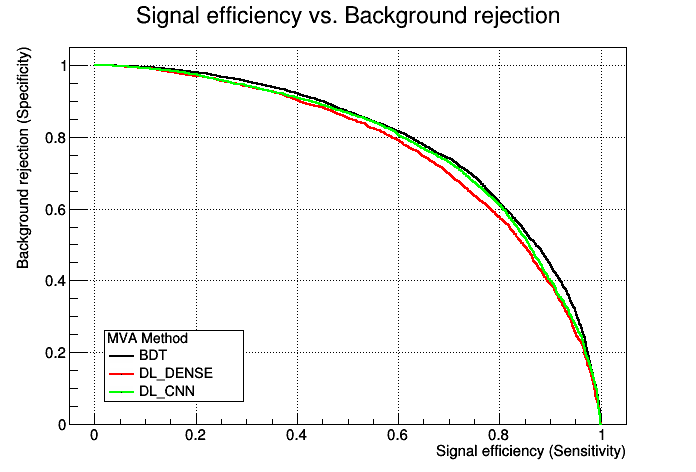

In [14]:
c1 = factory.GetROCCurve(loader);
c1->Draw();


In [15]:
// close outputfile to save output file
outputFile->Close();